# LSTM

Meng Jia

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras import Sequential
from keras.utils import plot_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import mode
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Paramesters needs tune

In [2]:
# the depth range which affect the prediction in LSTM:
dep_range = 6 # unit in meter
# features: 
#features_names = ['DEPT', 'GR', 'RHOB', 'NPHI', 'RESI']
features_names = ['GR', 'RHOB', 'NPHI', 'RESI']
n_features = len(features_names)
# target(s):
targets_names = ['DT']
n_targets = len(targets_names)
# training set, set up later: 
train_wells = ['BOYD_1_LWD_180_674.ASC', 
               'BREAKER-1.ASC', 
               'CHERVIL_1_WL_39_2661.LAS',
               'LEE_1_008.ASC',
               'LEE_2_006.ASC',
               'MISTINGUETT_1_LWD_649_2352.LAS',
               'NORTH_HERALD_1_WL_47_2608.LAS',
               'NORTH_GIPSY_1_003.LAS',
               'NORTH_HARRIET_1_004.ASC',
               'TEEWINOT_1_LWD_472_2252.ASC']
#train_wells = ['LEE_1_008.ASC']
# test set:
test_wells = ['JOSEPHIINE_1_LWD_690_2675.ASC', 
              'MONTY_1_LWD_61_2492.LAS']
# parameters in LSTM
batch_size = 100
n_epochs = 20

## Load in data

In [3]:
local = True
if local:
    df = pd.read_csv('welllogs.csv')
else: # use Google Colab
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv('welllogs.csv')

df.head()
        
    


,Unnamed: 0,DEPT,CALI,DT,GR,NPHI,RESI,RHOB,filename
0,0,710.1,9.077,158.0,108.654,61.64,0.590,2.13,BREAKER-1.ASC
1,1,710.7,9.782,152.9,99.889,50.45,0.988,2.15,BREAKER-1.ASC
2,2,711.5,8.687,152.4,116.795,62.38,0.714,2.14,BREAKER-1.ASC
3,3,711.6,8.687,155.6,114.532,63.24,0.751,2.14,BREAKER-1.ASC
4,4,712.2,8.651,157.5,122.552,61.74,0.606,2.12,BREAKER-1.ASC


## Create Scaler model

for later use

In [4]:
print('Training set: %d wells' % len(train_wells))
print('Test set: %d wells' % len(test_wells))
df_train = df[df['filename'].isin(train_wells)]
df_test = df[df['filename'].isin(test_wells)]

X_raw_train = df_train[features_names].to_numpy()
y_raw_train = df_train[targets_names].to_numpy()
if n_targets == 1:
    y_raw_train = y_raw_train.reshape((-1,1))
    
normalization = True
standardization = False
if normalization:
  scaler_X = MinMaxScaler().fit(X_raw_train)
  scaler_y = MinMaxScaler().fit(y_raw_train)
if standardization:
  scaler_X = StandardScaler().fit(X_raw_train) 
  scaler_y = StandardScaler().fit(y_raw_train)


Training set: 10 wells
Test set: 2 wells


## Create sequencial inputs X and single-value ouput y

### check sampling (depth interval) and determine LSTM time steps for each well

In [5]:
all_wells = pd.unique(df['filename'])
time_steps_dict = {}
print('Well name:                     Time steps:')
for well in all_wells:
    depth = df[df['filename']==well]['DEPT'].to_numpy()
    dp = mode(np.diff(depth))[0][0]
    time_steps = int(round(dep_range/dp, -1))
    time_steps_dict[well] = time_steps
    print('%30s %d' % (well, time_steps))

Well name:                     Time steps:
                 BREAKER-1.ASC 60
                 LEE_1_008.ASC 60
                 LEE_2_006.ASC 60
        BOYD_1_LWD_180_674.ASC 60
 JOSEPHIINE_1_LWD_690_2675.ASC 60
   TEEWINOT_1_LWD_472_2252.ASC 60
       NORTH_HARRIET_1_004.ASC 60
         NORTH_GIPSY_1_003.LAS 60
MISTINGUETT_1_LWD_649_2352.LAS 60
       MONTY_1_LWD_61_2492.LAS 60
      CHERVIL_1_WL_39_2661.LAS 40
 NORTH_HERALD_1_WL_47_2608.LAS 40


In [6]:
common_n_time_steps = max([time_steps_dict[key] for key in time_steps_dict.keys()])
X_seq_train = []
X_seq_test = []
y_train = []
y_test = []
y_test_names = []
for well in all_wells:
    print('Processing %s' % well)
    df_sub = df[df['filename']==well]
    n_samples = df_sub.shape[0]
    n_time_steps = time_steps_dict[well]
    n_sequences = n_samples - n_time_steps 
    n_sequences = (n_sequences//batch_size * batch_size)
    print('# of input sequences: %d' % n_sequences)
    X_seq_tmp = np.zeros((n_sequences, common_n_time_steps, n_features))
    y_tmp = np.zeros((n_sequences, n_targets))
    # deal with features
    features = df_sub[features_names].to_numpy()
    features_scaled = scaler_X.transform(features)
    targets = df_sub[targets_names].to_numpy()
    if n_targets == 1:
        targets = targets.reshape((-1,1))
    targets_scaled = scaler_y.transform(targets)
    for i_feature in range(features_scaled.shape[1]):
        for i_sequence in range(n_sequences):
            start = i_sequence
            end = start+n_time_steps-1
            feature_scaled_seq = features_scaled[start:end+1, i_feature] # 200-long sequences are padded with 0s
            X_seq_tmp[i_sequence, 0:len(feature_scaled_seq), i_feature] = feature_scaled_seq
    for i_target in range(targets_scaled.shape[1]):
        for i_sequence in range(n_sequences):
            start = i_sequence
            end = start+n_time_steps-1
            y_tmp[i_sequence, i_target] = targets_scaled[end+1 ,i_target]
    if well in train_wells:
        X_seq_train.append(X_seq_tmp)
        y_train.append(y_tmp)
    if well in test_wells:
        X_seq_test.append(X_seq_tmp)
        y_test.append(y_tmp) 
        y_test_names.append(well)
           
## Convert list to np.array
X_train = np.concatenate(X_seq_train, axis=0)
y_train = np.concatenate(y_train, axis=0)



Processing BREAKER-1.ASC
# of input sequences: 4600
Processing LEE_1_008.ASC
# of input sequences: 15400
Processing LEE_2_006.ASC
# of input sequences: 13200
Processing BOYD_1_LWD_180_674.ASC
# of input sequences: 1400
Processing JOSEPHIINE_1_LWD_690_2675.ASC
# of input sequences: 13800
Processing TEEWINOT_1_LWD_472_2252.ASC
# of input sequences: 10900
Processing NORTH_HARRIET_1_004.ASC
# of input sequences: 6500
Processing NORTH_GIPSY_1_003.LAS
# of input sequences: 13900
Processing MISTINGUETT_1_LWD_649_2352.LAS
# of input sequences: 10900
Processing MONTY_1_LWD_61_2492.LAS
# of input sequences: 11200
Processing CHERVIL_1_WL_39_2661.LAS
# of input sequences: 11300
Processing NORTH_HERALD_1_WL_47_2608.LAS
# of input sequences: 10500


## Training and test overview

In [7]:
print('well logs for test: ')
[print(well) for well in test_wells]
print('size of X_train set is (%d, %d, %d)' % X_train.shape)
print('size of X_test is (%d, %d, %d)' % np.concatenate(X_seq_test, axis=0).shape)
print('size of y_train set is (%d, %d)' % y_train.shape)
print('size of y_test set is (%d, %d)' % np.concatenate(y_test, axis=0).shape)

well logs for test: 
JOSEPHIINE_1_LWD_690_2675.ASC
MONTY_1_LWD_61_2492.LAS
size of X_train set is (98600, 60, 4)
size of X_test is (25000, 60, 4)
size of y_train set is (98600, 1)
size of y_test set is (25000, 1)


## LSTM Model

## create LSTM model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 4)             144       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________


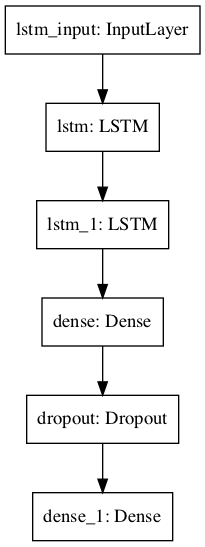

In [8]:
lstm1_dim = n_features
lstm2_dim = n_features
dense1_dim = 128
output_dim = n_targets


lstm_layers = [
              LSTM(lstm1_dim, input_shape=(common_n_time_steps,n_features), dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
              LSTM(lstm2_dim, dropout=0.2, recurrent_dropout=0.2),
              Dense(dense1_dim, activation='relu'),
              Dropout(0.2),
              Dense(output_dim, activation='relu')
              ]
simple_lstm = Sequential(lstm_layers)
simple_lstm.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])

# model summary
simple_lstm.summary()
# plot model structure
tf.keras.utils.plot_model(simple_lstm, to_file='model.png')

### train model

In [9]:
#history = simple_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.33)
history = simple_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 98600 samples
Epoch 1/20
98600/98600 [==============================] - 287s 3ms/sample - loss: 0.0271 - mean_absolute_error: 0.1006
Epoch 2/20
98600/98600 [==============================] - 294s 3ms/sample - loss: 0.0189 - mean_absolute_error: 0.0899
Epoch 3/20
98600/98600 [==============================] - 287s 3ms/sample - loss: 0.0192 - mean_absolute_error: 0.0910
Epoch 4/20
98600/98600 [==============================] - 283s 3ms/sample - loss: 0.0192 - mean_absolute_error: 0.0918
Epoch 5/20
98600/98600 [==============================] - 283s 3ms/sample - loss: 0.0190 - mean_absolute_error: 0.0912
Epoch 6/20
98600/98600 [==============================] - 282s 3ms/sample - loss: 0.0193 - mean_absolute_error: 0.0928
Epoch 7/20
98600/98600 [==============================] - 284s 3ms/sample - loss: 0.0184 - mean_absolute_error: 0.0915
Epoch 8/20
98600/98600 [==========================

### test results

Processing JOSEPHIINE_1_LWD_690_2675.ASC
13800/13800 [==============================] - 9s 623us/sample - loss: 0.0097 - mean_absolute_error: 0.0775
Test scores:
loss of simple LSTM is: 0.009665
mae of simple LSTM is: 0.077453
mape of simple LSTM is: 8.718402
Processing MONTY_1_LWD_61_2492.LAS
11200/11200 [==============================] - 6s 530us/sample - loss: 0.0080 - mean_absolute_error: 0.0768
Test scores:
loss of simple LSTM is: 0.008046
mae of simple LSTM is: 0.076781
mape of simple LSTM is: 8.928023


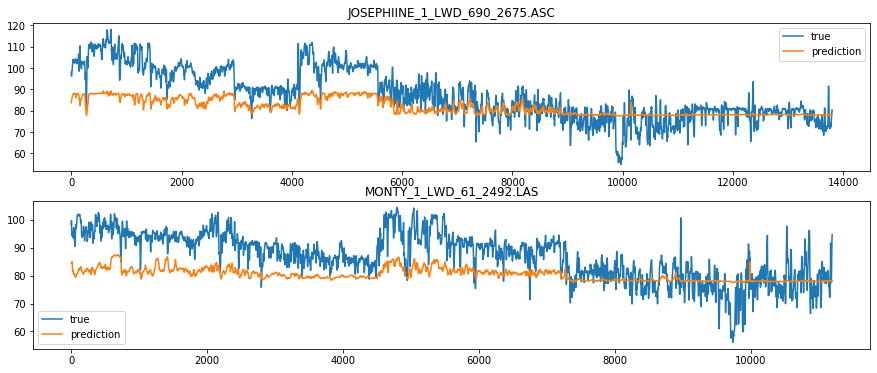

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''mape function
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# predict and plot testing results
fig, axs = plt.subplots(len(y_test),n_targets,figsize=(15,6), squeeze=False)
i = 0 # test data index
for X, y, well in zip(X_seq_test, y_test, y_test_names):
    print('Processing %s' % well)
    y_pre_scaled = simple_lstm.predict(X, batch_size=batch_size)
    y_pre = scaler_y.inverse_transform(y_pre_scaled)
    y_true = scaler_y.inverse_transform(y)
    filename = 'y_pre'+well
    np.save(filename, y_pre)
    [simple_lstm_loss, simple_lstm_mae] = simple_lstm.evaluate(X, y, batch_size=batch_size)
    simple_lstm_mape = mean_absolute_percentage_error(y_true, y_pre)
    print('Test scores:')
    print('loss of simple LSTM is: %f' % simple_lstm_loss)
    print('mae of simple LSTM is: %f' % simple_lstm_mae)
    print('mape of simple LSTM is: %f' % simple_lstm_mape)
    # plotting
    for j in range(n_targets):
        axs[i,j].plot(y_true[:,j])
        axs[i,j].plot(y_pre[:,j])
        axs[i,j].legend(('true', 'prediction'))
        axs[i,j].set_title(well)
    i+=1





## Save Model

In [11]:
from joblib import dump, load
dump(scaler_X, 'lstm_model.X_scaler') 
dump(scaler_y, 'lstm_model.y_scaler') 
simple_lstm.save('lstm_model.h5')

## Load model

In [12]:
from joblib import dump, load
model = tf.keras.models.load_model('lstm_model.h5')
scaler_y = load('lstm_model.y_scaler')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
